In [1]:
%load_ext autoreload
%autoreload 2

# imports
import time

# library imports
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pacswg.timer import TimerClass
import pacswg

from exp_trace_utils import get_time_with_tz
import exp_trace_utils

In [2]:
# configs
server_address = 'http://localhost:3000'

# service_name = 'tfserving-resnetv2'
# slo_timeout = 

# service_name = 'bentoml-onnx-resnet50'
# slo_timeout = 

# service_name = 'bentoml-iris'
# service_url = f'{server_address}/proxy/{service_name}'
# slo_timeout = 500
# initial_batch_size = 5
# bs_config = {
#     'max_bs': 100,
#     'min_bs': 1,
#     'inc_step': 5,
#     'dec_mult': 0.7,
# }
# average_timeout_ratio_threshold = 0.5

# service_name = 'tfserving-mobilenetv1'
# slo_timeout = 

# service_name = 'bentoml-keras-toxic-comments'
# service_url = f'{server_address}/proxy/{service_name}'
# slo_timeout = 500
# initial_batch_size = 5
# bs_config = {
#     'max_bs': 100,
#     'min_bs': 1,
#     'inc_step': 5,
#     'dec_mult': 0.7,
# }
# average_timeout_ratio_threshold = 0.5

service_name = 'bentoml-pytorch-fashion-mnist'
service_url = f'{server_address}/proxy/{service_name}'
slo_timeout = 1000
initial_batch_size = 5
bs_config = {
    'max_bs': 100,
    'min_bs': 1,
    'inc_step': 5,
    'dec_mult': 0.7,
}
average_timeout_ratio_threshold = 0.5

# SLO Target
slo_target = slo_timeout * 0.8

# length of measurements used to estimate different batch size response times
upstream_rt_max_len = 1000

# disable controller?
disable_controller = True
if disable_controller:
    initial_batch_size = 1

# experiment info
cpu_m = 1000
ram_mb = 1024

controller = exp_trace_utils.SmartProxyController(
    server_address=server_address,
    service_name=service_name,
    slo_timeout=slo_timeout,
    initial_batch_size=initial_batch_size,
    bs_config=bs_config,
    average_timeout_ratio_threshold=average_timeout_ratio_threshold,
)

loading file: ../traces/files/AutoScale/trace_wc.txt


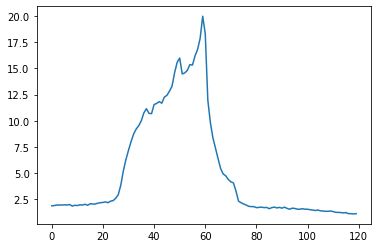

In [3]:
# initialize trace values

# staircase workload
# base_rps = 5
# rps_list = [base_rps] * 5 + [base_rps*2] * 5 + [base_rps*3] * 5 + [base_rps*4] * 5
# trace_name = 'staircase'

# autoscale traces
trace_name = 'trace_wc'
max_rps = 20
autoscale_folder_path = '../traces/files/AutoScale/'
autoscale_trace_file_names = {
  # Big Spike, NLANR [nlanr1995]
  'trace_t2': 'trace_t2.txt',
  # Dual Phase, NLANR [nlanr1995]
  'trace_t4': 'trace_t4.txt',
  # Large variations, NLANR [nlanr1995]
  'trace_t5': 'trace_t5.txt',
  # worldcup, slowly varying [ita 1998]
  'trace_wc': 'trace_wc.txt',
}
autoscale_file_path = autoscale_folder_path + autoscale_trace_file_names[trace_name]
print('loading file:', autoscale_file_path)
trace_arr = np.loadtxt(autoscale_file_path)
rps_list = trace_arr / (trace_arr.max()) * max_rps
rps_list = list(rps_list)

plt.plot(rps_list)

# Getting and Setting Stats and Configs

In [4]:
controller.set_initial_config()

{'serviceName': 'bentoml-pytorch-fashion-mnist',
 'upstreamUrl': 'http://bentoml-pytorch-fashion-mnist.default.192-168-23-125.nip.io/predict',
 'maxBufferTimeoutMs': 800,
 'maxBufferSize': 1,
 'isTFServing': False}

In [5]:
proxy_stats = controller.get_proxy_stats()
proxy_stats

{'maxBufferSize': 1,
 'averageMaxBufferSize': 2.8,
 'averageActualBatchSize': None,
 'maxBufferTimeoutMs': 800,
 'currentReplicaCount': 0,
 'currentReadyReplicaCount': 0,
 'currentConcurrency': 0,
 'averageConcurrency': 0,
 'averageArrivalRate': 0,
 'averageDepartureRate': 0,
 'averageDispatchRate': 0,
 'averageErrorRate': 0,
 'averageTimeoutRatio': None,
 'reponseTimeAverage': None,
 'reponseTimeP50': None,
 'reponseTimeP95': None,
 'batchResponseTimeStats': {}}

In [6]:

batch_rt_values = controller.update_batch_rt_values()
# batch_rt_values

In [7]:
# run a loop to monitor response times to test the functionality
# timer = TimerClass()

# batch_rt_values = {}
# for _ in tqdm(range(1*6)):
#     timer.tic()
#     controller.update_batch_rt_values()
#     while timer.toc() < 10:
#         time.sleep(.1)

# batch_rt_values = controller.get_batch_rt_values()
# batch_rt_values

In [8]:
def analyze_batch_results(batch_rt_values):
    batch_size_results = []
    for bs, vals in batch_rt_values.items():
        # print(bs, len(vals), np.mean(vals))
        batch_size_results.append({
            'batch_size': bs,
            'average_response_time': np.mean(vals),
            'median_response_time': np.median(vals),
            'p95_response_time': np.percentile(vals,95),
        })

    df_batch_size = pd.DataFrame(data=batch_size_results)
    df_batch_size = df_batch_size.sort_values(by='batch_size')
    return df_batch_size

def plot_key_vs_batch_size(key, df_batch_size):
    plt.figure()
    plt.plot(df_batch_size['batch_size'], df_batch_size[key], marker='x')
    prev_ylim = plt.gca().get_ylim()
    # relative average response time by batch size (linear scale)
    relative_scaled_response_time = df_batch_size['batch_size']/df_batch_size['batch_size'].iloc[0]*df_batch_size[key].iloc[0]
    # plot the linear baseline
    plt.plot(df_batch_size['batch_size'], relative_scaled_response_time, ls='--')
    plt.ylim(prev_ylim)
    plt.title(key)

# df_batch_size = analyze_batch_results(batch_rt_values)
# display(df_batch_size)
# plot_key_vs_batch_size('average_response_time', df_batch_size)
# plot_key_vs_batch_size('median_response_time', df_batch_size)
# plot_key_vs_batch_size('p95_response_time', df_batch_size)

# Perform Experiment and Log Results

In [9]:
# my imports
from helpers import kube
from helpers import workload
from helpers import util
from helpers import request_funcs

using domain 192-168-23-125.nip.io
fetching imagenet v2
resizing images


  0%|          | 0/100 [00:00<?, ?it/s]

converting to bentoml files


  0%|          | 0/100 [00:00<?, ?it/s]

extracting base64 files


  0%|          | 0/100 [00:00<?, ?it/s]

preprocessing for mobilenet


  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
config_names = [
    'bentoml-iris-250m-512mb',
    'bentoml-onnx-resnet50-250m-512mb',
    'tfserving-resnetv2-250m-512mb',
    'tfserving-mobilenetv1-250m-512mb',
    'bentoml-pytorch-fashionmnist-250m-512mb',
    'bentoml-keras-toxic-comments-250m-512mb',
]

workload_configs = {}
for exp_config_name in config_names:
    exp_file = f"deployments/{exp_config_name}.json"
    workload_spec = util.load_json_file(exp_file)
    workload_configs[workload_spec['name']] = workload_spec

In [11]:
# deploy the function
request_limit_override = f"'cpu={cpu_m}m,memory={ram_mb}Mi'"
print('Request Limit Override:', request_limit_override)

workload_spec = workload_configs[service_name]
# override request and limit values
workload_spec['opts']['--request'] = request_limit_override
workload_spec['opts']['--limit'] = request_limit_override
kn_command = kube.get_kn_command(**workload_spec)
print(kn_command)
!{kn_command}
print('waiting for settings to converge')
time.sleep(10)

Request Limit Override: 'cpu=1000m,memory=1024Mi'
kn service apply bentoml-pytorch-fashion-mnist --image ghcr.io/nimamahmoudi/bentoml-pytorch-fashion-mnist:20210614122950 \
  --limit 'cpu=1000m,memory=1024Mi' \
  --request 'cpu=1000m,memory=1024Mi' \
  --port 5000 \
  -a autoscaling.knative.dev/target=1 \
  -a autoscaling.knative.dev/metric=concurrency
No changes to apply to service 'bentoml-pytorch-fashion-mnist'.
Service 'bentoml-pytorch-fashion-mnist' with latest revision 'bentoml-pytorch-fashion-mnist-00022' (unchanged) is available at URL:
http://bentoml-pytorch-fashion-mnist.default.192-168-23-125.nip.io
waiting for settings to converge


In [12]:
# call the request function with proper arguments
def call_request_func():
    request_func = request_funcs.workload_funcs[service_name]
    result = request_func(url=service_url)

    return {
        'response_time_ms': result['response_time_ms'],
        'request_id': result['headers']['X-Request-Id'],
        'queue_position': int(result['headers']['X-SmartProxy-queuePosition']),
        'received_at': exp_trace_utils.from_js_timestamp(int(result['headers']['X-SmartProxy-receivedAt'])),
        'response_at': exp_trace_utils.from_js_timestamp(int(result['headers']['X-SmartProxy-responseAt'])),
        'upstream_response_time': int(result['headers']['X-SmartProxy-upstreamResponseTime']),
        'upstream_request_count': int(result['headers']['X-SmartProxy-upstreamRequestCount']),
        'response_time_ms_server': int(result['headers']['X-SmartProxy-responseTime']),
        'queue_time_ms': int(result['headers']['X-SmartProxy-queueTime']),
    }

# adding exception handling to create worker func
def worker_func():
    try:
        return call_request_func()
    except Exception:
        print('exception occured:')
        traceback.print_exc()
        return None

worker_func()

{'response_time_ms': 2918.2290000000003,
 'request_id': '3d58c39a-30ad-4e9f-b884-1c183677b264',
 'queue_position': 0,
 'received_at': datetime.datetime(2021, 7, 28, 16, 6, 4, 415000, tzinfo=<DstTzInfo 'America/Toronto' EDT-1 day, 20:00:00 DST>),
 'response_at': datetime.datetime(2021, 7, 28, 16, 6, 7, 327000, tzinfo=<DstTzInfo 'America/Toronto' EDT-1 day, 20:00:00 DST>),
 'upstream_response_time': 2910,
 'upstream_request_count': 1,
 'response_time_ms_server': 2912,
 'queue_time_ms': 2}

In [13]:
# perform the experiment

# start the controller
if disable_controller:
    controller.disable_controller()
    
controller.set_initial_config()
controller.start_control_thread()

# start workload generator
wg = pacswg.WorkloadGenerator(worker_func=worker_func, rps=0, worker_thread_count=300)
wg.start_workers()
timer = TimerClass()

print("============ Experiment Started ============")
print("Time Started:", get_time_with_tz())

for rps in tqdm(rps_list):
    wg.set_rps(rps)
    timer.tic()
    # apply each for one minute
    while timer.toc() < 60:
        wg.fire_wait()

# get the results
wg.stop_workers()
all_res = wg.get_stats()
total_reqs = len(all_res)
all_res = [d for d in all_res if d is not None]
success_reqs = len(all_res)

print("Total Requests Made:", total_reqs)
print("Successful Requests Made:", success_reqs)

Controller Disabled!!!
============ Experiment Started ============
Time Started: 2021-07-28 16:06:08.889015-04:00


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
# collect the results
df_res = pd.DataFrame(data=all_res)
# save the results
now = get_time_with_tz()
res_name = now.strftime('res-%Y-%m-%d_%H-%M-%S')
res_folder = f'results/trace_{trace_name}/{service_name}'
# make the directory and file names
! mkdir -p {res_folder}
requests_results_filename = f'{res_name}_reqs.csv'
proxy_results_filesname = f'{res_name}_proxy.csv'
if disable_controller:
    requests_results_filename.replace('.csv', '_no_controller.csv')
    proxy_results_filesname.replace('.csv', '_no_controller.csv')

df_res.to_csv(os.path.join(res_folder, requests_results_filename))
print('Results Name:', res_name)

Results Name: res-2021-06-30_08-43-15


In [ ]:
# stop the controller to save the results
controller.stop_control_thread()

In [ ]:
df_proxy_stats = pd.DataFrame(data=controller.acc_proxy_stats)
df_proxy_stats.to_csv(os.path.join(res_folder, proxy_results_filesname))
df_proxy_stats.head()

,maxBufferSize,averageMaxBufferSize,averageActualBatchSize,maxBufferTimeoutMs,currentReplicaCount,currentReadyReplicaCount,currentConcurrency,averageConcurrency,averageArrivalRate,averageDepartureRate,averageDispatchRate,averageErrorRate,averageTimeoutRatio,reponseTimeAverage,reponseTimeP50,reponseTimeP95,batchResponseTimeStats
0,1,1,NaN,800,2,0,0,0.2,0.05,0.00,0.05,0,0,NaN,NaN,NaN,{}
1,1,1,1.0,800,2,2,0,0.7,4.55,4.50,4.55,0,0,133.369565,30.5,354.6,"{'1': {'values': [11, 11, 11, 11, 12, 12, 12, ..."
2,1,1,1.0,800,2,2,1,0.3,4.75,4.75,4.75,0,0,109.771127,23.5,344.1,"{'1': {'values': [11, 11, 11, 11, 11, 11, 11, ..."
3,1,1,1.0,800,3,3,1,1.0,5.05,5.20,5.05,0,0,128.580000,35.0,375.5,"{'1': {'values': [11, 11, 11, 11, 11, 11, 11, ..."
4,1,1,1.0,800,3,3,0,1.2,5.60,5.55,5.60,0,0,144.066879,75.0,400.8,"{'1': {'values': [11, 11, 11, 11, 11, 11, 11, ..."
